In [1]:
# Step 0. Import libraries and custom modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
# Preprocessing --------------------------------------------------
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Metrics --------------------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Exporting ------------------------------------------------------------
import pickle

In [2]:
# Step 1. Read the dataset
# The data this week comes from Coffee Quality Database courtesy of Buzzfeed Data Scientist 
# James LeDoux. The original data can be found on James' github. The data was re-posted to Kaggle.
# These data were collected from the Coffee Quality Institute's review pages in January 2018.
# There is data for both Arabica and Robusta beans, across many countries and professionally 
# rated on a 0-100 scale. All sorts of scoring/ratings for things like acidity, sweetness, fragrance, 
# balance, etc - may be useful for either separating into visualizations/categories or for 
# modeling/recommenders.
# https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-07-07/readme.md
url = 'https://raw.githubusercontent.com/rfordatascience/' + \
'tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv'
df_raw = pd.read_csv(url)
df_raw.to_csv('../data/raw/coffee.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cup_points       1339 non-null   float64
 1   species                1339 non-null   object 
 2   owner                  1332 non-null   object 
 3   country_of_origin      1338 non-null   object 
 4   farm_name              980 non-null    object 
 5   lot_number             276 non-null    object 
 6   mill                   1021 non-null   object 
 7   ico_number             1180 non-null   object 
 8   company                1130 non-null   object 
 9   altitude               1113 non-null   object 
 10  region                 1280 non-null   object 
 11  producer               1107 non-null   object 
 12  number_of_bags         1339 non-null   int64  
 13  bag_weight             1339 non-null   object 
 14  in_country_partner     1339 non-null   object 
 15  harv

In [3]:
df_raw.sample(10)

,total_cup_points,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1181,79.33,Arabica,juan luis alvarado romero,Guatemala,conquista / morito,NaN,beneficio ixchel,11/23/0122,"unex guatemala, s.a.",NaN,...,Green,6,"January 12th, 2013",Asociacion Nacional Del Café,b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53,724f04ad10ed31dbb9d260f0dfd221ba48be8a95,m,NaN,NaN,NaN
73,85.42,Arabica,nucoffee,Brazil,fazenda serra de três barras,NaN,NaN,002/1251/0072,nucoffee,1250m,...,Blue-Green,1,"December 2nd, 2012",NUCOFFEE,567f200bcc17a90070cb952647bf88141ad9c80c,aa2ff513ffb9c844462a1fb07c599bce7f3bb53d,m,1250.0,1250.0,1250.0
30,86.58,Arabica,nora zeas,Nicaragua,NaN,NaN,beneficio atlantic condega,790-0013,NaN,NaN,...,NaN,2,"May 18th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,NaN,NaN,NaN
338,83.58,Arabica,yunnan coffee exchange,China,menglian mang pan professional cooperative,YNC-16029,menglian mang pan professional cooperative,NaN,yunnan coffee exchange,1100,...,Green,4,"April 6th, 2017",Yunnan Coffee Exchange,683fa6014608fc10ff681b0435b0b2dbe6df988f,f6d87a6c04653c569d4911a66f89d5e30ce83b93,m,1100.0,1100.0,1100.0
558,82.92,Arabica,doi tung development project,Thailand,doi tung development project,NaN,NaN,NaN,NaN,NaN,...,NaN,0,"April 13th, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,NaN,NaN,NaN
18,87.25,Arabica,yunnan coffee exchange,China,echo coffee,YNC-06114,echo coffee mill,NaN,yunnan coffee exchange,1450,...,Green,0,"April 7th, 2017",Yunnan Coffee Exchange,683fa6014608fc10ff681b0435b0b2dbe6df988f,f6d87a6c04653c569d4911a66f89d5e30ce83b93,m,1450.0,1450.0,1450.0
712,82.33,Arabica,ipanema coffees,Brazil,rio verde,NaN,ipanema coffees,002/1660/0107,ipanema coffees,1268,...,Green,0,"October 7th, 2016",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1268.0,1268.0,1268.0
123,84.75,Arabica,the coffee source inc.,El Salvador,several,NaN,la majada cooperative,9-29-1986,NaN,1200 mts,...,NaN,3,"August 22nd, 2012",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1200.0,1200.0,1200.0
1017,80.92,Arabica,min hlaing,Myanmar,sithar coffee farm,NaN,local made,unspecified,"sithar coffee co., ltd.",3500 ft,...,NaN,5,"July 16th, 2016",Coffee Quality Institute,1d4c7f93129f9fb1c8a5f0ce0e36cc1cf4c2f4d7,0f62c9236e3ff5c4921da1e22a350aa99482779d,ft,1066.8,1066.8,1066.8
1052,80.67,Arabica,"ceca, s.a.",Costa Rica,gamboa,NaN,beneficio montañas del diamante,5-025-0048,"ceca,s.a.",1.85,...,Blue-Green,4,"February 27th, 2016",Specialty Coffee Association of Costa Rica,8e0b118f3cf3121ab27c5387deacdb7d4d2a60b1,5eb2b7129d9714c43825e44dc3bca9423de209e9,m,185.0,185.0,185.0


In [17]:
# 1.2 Transform data
# Select metrics
df_interim = df_raw.copy()
# Select columns
df_interim = df_interim[['total_cup_points',
                         'species',
                         'country_of_origin',
                         'variety',
                         'aroma',
                         'aftertaste',
                         'acidity',
                         'body',
                         'balance',
                         'sweetness',
                         'altitude_mean_meters',
                         'moisture']]
df_interim = df_interim.dropna()

top_varieties = ['Caturra','Typica','Bourbon','Catuai','Yellow Bourbon'] # En el other vamos a meter el otro
df_interim['variety'] = df_interim['variety'].apply(lambda x: x if x in top_varieties else 'Other')

top_countries = ['Mexico','Guatemala','Colombia','Brazil','Taiwan','Honduras','Costa Rica','Tanzania, United Republic Of']
df_interim['country_of_origin'] = df_interim['country_of_origin'].apply(lambda x: x if x in top_countries else 'Other')

df_interim['specialty'] = df_interim['total_cup_points'].apply(lambda x: 'Yes' if x > 80 else 'No')

df_interim['variety'] = pd.Categorical(df_interim['variety'])
df_interim['country_of_origin'] = pd.Categorical(df_interim['country_of_origin'])
df_interim['species'] = pd.Categorical(df_interim['species'])
df_interim['specialty'] = pd.Categorical(df_interim['specialty'])

#Como hemos creado la columna specialty, podemos botar la columna total_cup_points
df_interim = df_interim.drop(['total_cup_points'], axis=1)

df_interim.to_csv('../data/interim/coffee_model_interim.csv')

df = df_interim.copy()

In [18]:
# 3. EDA

X = df.copy().drop(['specialty'],axis=1)
y = df['specialty'].copy()

# 3.1. Create Train and Test subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2007) #Stratify: stratificar entre yes y no de specialty
df_train = pd.concat([X_train, y_train], axis=1)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 1178 to 1165
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   species               747 non-null    category
 1   country_of_origin     747 non-null    category
 2   variety               747 non-null    category
 3   aroma                 747 non-null    float64 
 4   aftertaste            747 non-null    float64 
 5   acidity               747 non-null    float64 
 6   body                  747 non-null    float64 
 7   balance               747 non-null    float64 
 8   sweetness             747 non-null    float64 
 9   altitude_mean_meters  747 non-null    float64 
 10  moisture              747 non-null    float64 
 11  specialty             747 non-null    category
dtypes: category(4), float64(8)
memory usage: 56.3 KB


In [20]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
species,747,2,Arabica,745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_of_origin,747,9,Mexico,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,747,6,Other,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aroma,747.0,NaN,NaN,NaN,7.567095,0.28436,6.5,7.42,7.58,7.75,8.75
aftertaste,747.0,NaN,NaN,NaN,7.386399,0.323808,6.17,7.25,7.42,7.58,8.58
acidity,747.0,NaN,NaN,NaN,7.52407,0.301195,5.25,7.33,7.5,7.67,8.58
body,747.0,NaN,NaN,NaN,7.505234,0.265359,6.42,7.33,7.5,7.67,8.42
balance,747.0,NaN,NaN,NaN,7.500857,0.333181,6.08,7.33,7.5,7.67,8.58
sweetness,747.0,NaN,NaN,NaN,9.925181,0.469957,1.33,10.0,10.0,10.0,10.0
altitude_mean_meters,747.0,NaN,NaN,NaN,1979.917018,10546.81805,1.0,1100.0,1310.64,1600.0,190164.0


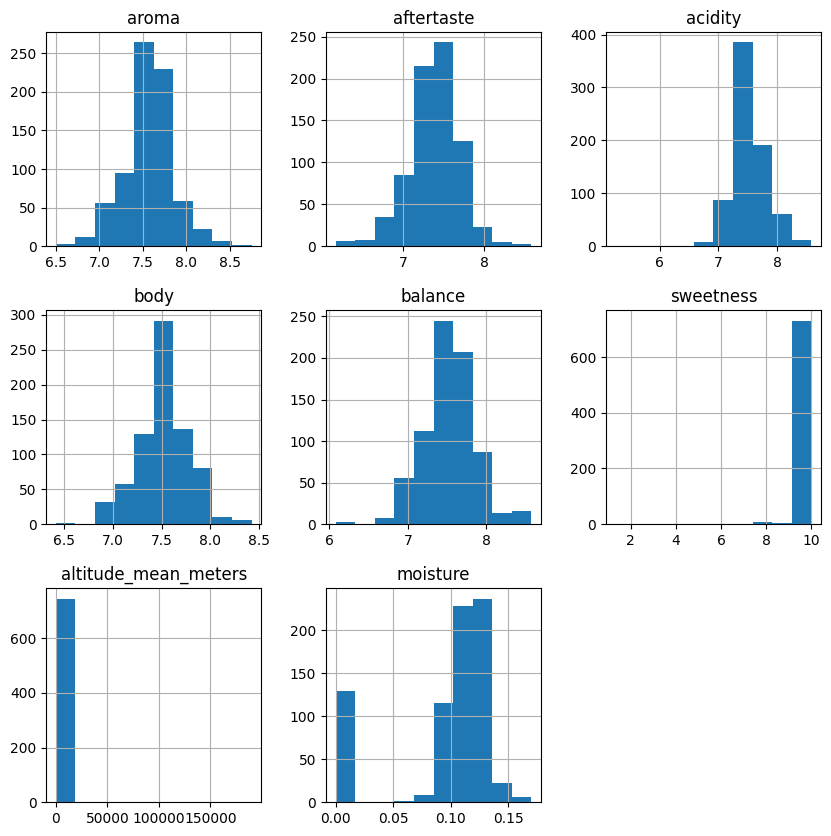

In [22]:
#Es necesario hacer un analsis univariado. Cada variable por separado. Solo en variables numericas. No en categoricas

df_train.hist(figsize=(10,10))
plt.show()

# Near 0 variation => sweetness is candidate to be removed. Do not aport to the study or calsification
# Same with altitude_mean_meters

/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/coffee_quality/.venv/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


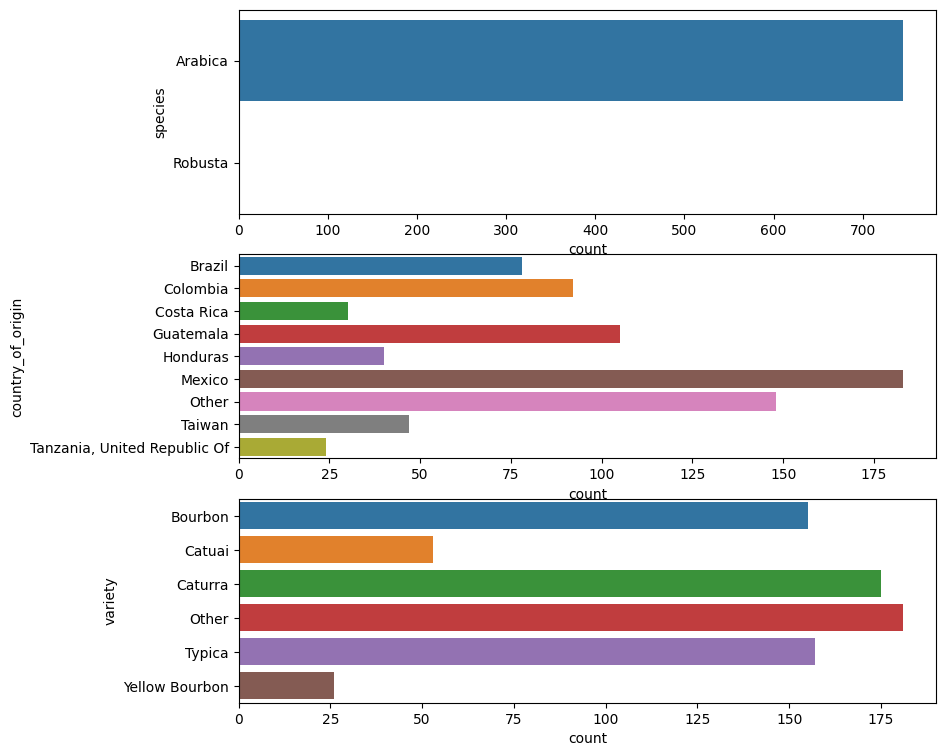

In [23]:
#Analisis univariado de variables categoricas

cats = df_train.select_dtypes('category') #cats de categoricas. select_dtypes get only columns for type

fig,ax = plt.subplots(3, 1, figsize = (9,9))

axs = ax.flatten() #flatten para no darle coordenadas, solo los indices

for i in range(len(axs)):
    sns.countplot(data=cats, y=cats.columns.to_list()[i], ax = axs[i])

plt.show()

In [ ]:
#Species no provee ninguna variedad 100 a 1 o 1000 a 1, puede ser descartada